# Model Validation

## Using cross-validation for hyperparameter tuning

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, balanced_accuracy_score
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

import pickle

In [7]:
# generate some random data with two variables: x and y,
# which are related by a cubic function + epsilon
# and epsilon is a random noise N(0, 10)

np.random.seed(123)
epsilon = np.random.normal(0, 10, 200)

x = np.random.uniform(-3, 3, 200)
y = x**3 + 4*x**2 - 3 * x + 4 + epsilon

data1 = pd.DataFrame({'x': x, 'y': y})

data1.head()

,x,y
0,-1.570501,3.847488
1,1.846747,28.373384
2,2.369870,35.495164
3,-2.740663,6.618216
4,-1.188319,5.749335


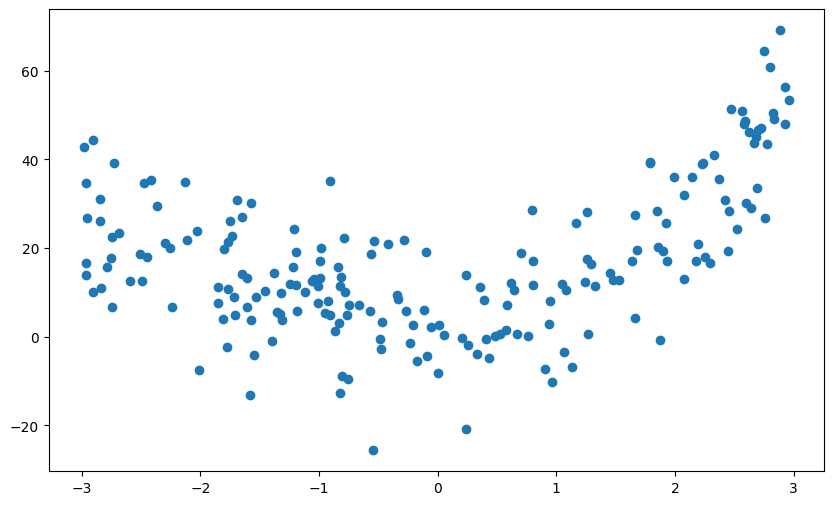

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(data1.x, data1.y)

RMSE: 15.496969323356865


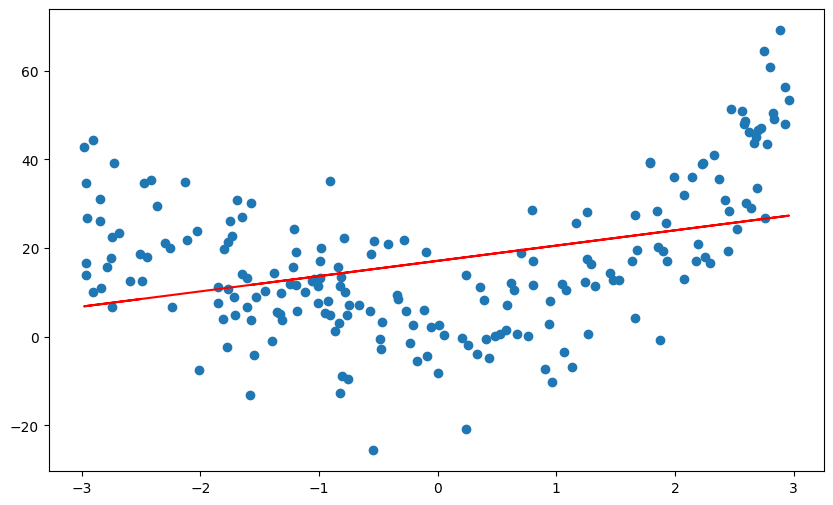

In [19]:
# and try to fit a linear regression model to this data

# create a linear regression model
model1 = LinearRegression()

# fit the model
model1.fit(data1[['x']], data1['y'])

# make predictions
y_pred = model1.predict(data1[['x']])

# plot the data and the model
plt.figure(figsize=(10, 6))
plt.scatter(data1['x'], data1['y'])
plt.plot(data1['x'], y_pred, color = 'red')

# and assess the RMSE of the model
rmse = np.sqrt(mean_squared_error(data1['y'], y_pred))

print('RMSE:', rmse)

In [21]:
# assume the test data has the same distribution as the training data
# but with the opposite sign of the noise

y_test = x**3 + 4*x**2 - 3 * x + 4 - epsilon

# put them into a dataframe
data1_test = pd.DataFrame({'x': x, 'y': y_test})

In [23]:
# now we will estimate polynomial regression models of different degrees from 1 to 30
# and compare their RMSE both on the training and test data

degrees = np.arange(1, 31)

# create a list to store resuls (more efficient than appending to DataFrame in loop)
results_list = []

for degree in degrees:
    # create a polynomial regression model
    model = np.polyfit(data1['x'], data1['y'], degree)

    # make predictions - the values of x are the same for both training and test data
    y_pred = np.polyval(model, data1['x'])

    # calculate the RMSE
    rmse_train = np.sqrt(mean_squared_error(data1['y'], y_pred))
    rmse_test = np.sqrt(mean_squared_error(data1_test['y'], y_pred))

    # append results as a dictionary
    results_list.append(
        {
            'degree': degree,
            'rmse_train': rmse_train,
            'rmse_test': rmse_test
        }
    )

# convert the list to a DataFrame after the loop (efficient)
results = pd.DataFrame(results_list)

results.tail()

,degree,rmse_train,rmse_test
25,26,9.930563,12.131000
26,27,9.926652,12.140600
27,28,9.876622,12.262400
28,29,9.861619,12.298571
29,30,9.859016,12.304829


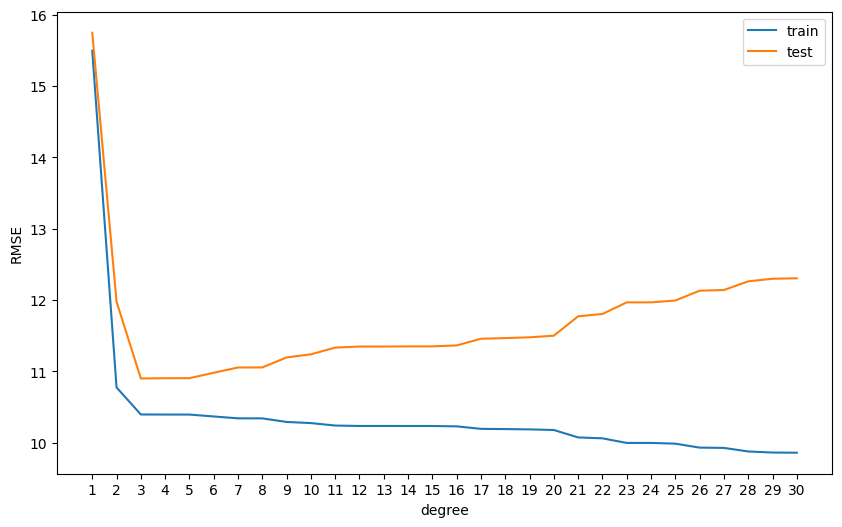

In [45]:
plt.figure(figsize = (10, 6))
plt.plot(results['degree'], results['rmse_train'], label = 'train')
plt.plot(results['degree'], results['rmse_test'], label = 'test')

plt.xticks(results['degree'])  # x ticks what is in down part from 1 to 30
plt.xlabel('degree')
plt.ylabel('RMSE')
plt.legend(loc = 'upper right')
plt.grid(False)
plt.show()

In [47]:
# use 5-fold cross-validation to find the optimal degree for Polynomial Regression

cv5 = KFold(
    n_splits = 5, # number of folds
    shuffle = True, # shuffle the data before splitting
    random_state = 123 # when shuffle is true, random_state affects the ordering
                       # of indices
)

In [55]:
# for hyperparameter tuning we will use grid search
# ex: define a particular grid (list of values) of parameters

# it is a bit more tricky to use GridSearchCV() function 
# with a polynomial regression - np.polyfit() does not work with GridSearchCV()

# we need to use PolynomialFeatures() transformer from sklearn.preprocessing
# - it generates polynomial and interaction features for All features in the dataset

poly = PolynomialFeatures(
    degree = 4, # Generates x, x^2, x^3, x^4 for each feature
    interaction_only = False, # No interaction terms (like x1 * x2).
    include_bias = False # Remove the constant (intercept) column
)

X_poly = poly.fit_transform(data1[['x']])

# lets see the first 5 rows of the transformed data
print(X_poly[:5])

# compare with the original data
print(data1[['x']].head())

# It transformed the original feature(s) into polynomial features.
# down are x, x^2, x^3, x^4 results, 4 columns: 4 results

[[ -1.57050057   2.46647203  -3.87359571   6.08348426]
 [  1.84674652   3.4104727    6.29827858  11.63132404]
 [  2.36986973   5.61628252  13.30985793  31.54262939]
 [ -2.74066265   7.51123175 -20.58575229  56.41860236]
 [ -1.18831898   1.412102    -1.67802762   1.99403207]]
          x
0 -1.570501
1  1.846747
2  2.369870
3 -2.740663
4 -1.188319


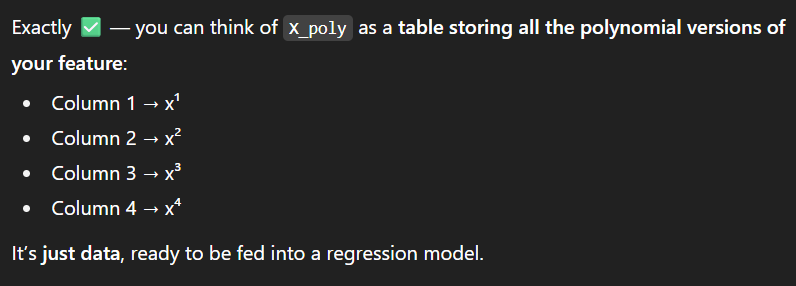

## Pipeline with LinearRegression()

We will use it in a **pipeline** with a `LinearRegression()` function

* **Pipelines** in scikit-learn streamline machine learning workflows by **chaining preprocessing steps and models into a single sequence**.

* This ensures that transformations (e.g., scaling, encoding, polynomial feature generation) and model fitting occur **consistently during training and prediction**

* Pipelines improve code readability, reproducibility, and **prevent data leakage** by **ensuring transformations are applied only on training data** before model evaluation

In [66]:
# create a pipeline with two steps

poly_pipeline = Pipeline(
    [
        ('generator', PolynomialFeatures()), # generate polynomial features
        ('model', LinearRegression()) # apply the model
    ]
)


# we need to define a grid of hyperparameters for the PolynomailFeatures() transformer
# it has to be a dictionary with the name of the step and the name of the hyperparameter
# as defined in the pipeline and algorithm documentation

# ex: here we use the name "generator__degree" because
# our pipeline step is named "generator" and the hyperparameter of the 
# PolynomialFeatures() transformer is named "degree"

polyreg_grid = {'generator__degree': degrees}

# finally we define a GridSearchCV object to find the optimal degree

poly_grid_search = GridSearchCV(
    poly_pipeline, # model or pipeline to tune
    param_grid = polyreg_grid, # dictionary with hyperparameters
    cv = cv5, # cross-validation strategy
    # python assumes the higher the better,
    # that's why we use negative RMSE
    scoring = 'neg_root_mean_squared_error', # evaluation metric
    n_jobs = -1   # use all available CPU cores (optional)
)

In [68]:
# now we treat the defined grid_search object as a regular model
X = data1.drop(columns = 'y') # or data1['x']
y = data1['y']

# fit on the training data
poly_grid_search.fit(X, y)

print('Best degree:', poly_grid_search.best_params_)
print('Best -RMSE:', poly_grid_search.best_score_)

# the result is in line with expectations

Best degree: {'generator__degree': 3}
Best -RMSE: -10.54448880089488


In [70]:
# let's see what were the results for each degree value

# GridSearch result contains an element called cv_results_

# convert results to a DataFrame
poly_grid_search_df = pd.DataFrame(poly_grid_search.cv_results_)

poly_grid_search_df.head()

# Column Description
# param_*               Hyperparameter values being tested
# mean_test_score       Average score for a given set of hyperparameters
# std_test_score        Standard deviation of cross-validation results
# rank_test_score       Rank of the hyperparameter set (1 = best)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_generator__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.036419,0.000000,0.003973,0.000401,1,{'generator__degree': 1},-15.394207,-15.812077,-17.826860,-13.957795,-15.626581,-15.723504,1.238346,30
1,0.024053,0.015144,0.003104,0.000973,2,{'generator__degree': 2},-11.257249,-9.243452,-12.457009,-10.790088,-10.772356,-10.904031,1.031925,7
2,0.005516,0.001022,0.003301,0.001076,3,{'generator__degree': 3},-11.489866,-8.574091,-12.200429,-10.135614,-10.322444,-10.544489,1.243770,1
3,0.004679,0.000681,0.002393,0.000496,4,{'generator__degree': 4},-11.591405,-8.583457,-12.409769,-10.147530,-10.333090,-10.613050,1.311466,2
4,0.004801,0.000980,0.002401,0.000374,5,{'generator__degree': 5},-11.833596,-8.607393,-12.620034,-10.171256,-10.524485,-10.751353,1.389084,3


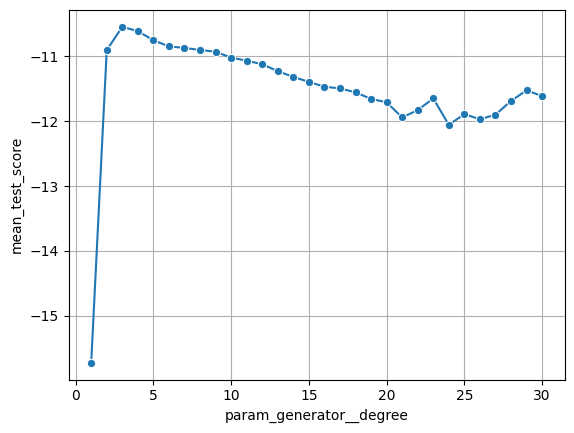

In [76]:
# plot the results

sns.lineplot(
    x = poly_grid_search_df['param_generator__degree'],
    y = poly_grid_search_df['mean_test_score'],
    marker = 'o'
)
plt.grid()

In [78]:
# apply the repeated cross-validation
# we will use 5-fold cross-validation repeated 3 times

X = data1.drop(columns = 'y') # or data1['x']
y = data1['y']

# create a repeated k-fold object

cv5x3 = RepeatedKFold(
    n_splits = 5, # Number of folds
    n_repeats = 3, # Number of repetitions
    random_state = 123
)

poly_grid_search2 = GridSearchCV(
     poly_pipeline, # same model as before
     param_grid = polyreg_grid, # same grid as before
     cv = cv5x3, # Difference: repeated cross-validation
     scoring = 'r2', # Difference: R^2 metric
     n_jobs = -1 # use all available CPU cores (optional)
)

# fit on training data
poly_grid_search2.fit(X, y)

print('Best degree:', poly_grid_search2.best_params_)
print('Best R2:', poly_grid_search2.best_score_)

Best degree: {'generator__degree': 3}
Best R2: 0.5729739915470716


In [84]:
poly_grid_search2.cv_results_

{'mean_fit_time': array([0.05736836, 0.00440137, 0.00371895, 0.00454634, 0.00396137,
        0.00546641, 0.00479568, 0.01076361, 0.01131317, 0.00886812,
        0.01370163, 0.01092683, 0.01610862, 0.01178417, 0.00815903,
        0.0096471 , 0.01036544, 0.00874351, 0.01092049, 0.01147529,
        0.01187143, 0.00753713, 0.01036604, 0.00967336, 0.010077  ,
        0.01043181, 0.00672617, 0.00701569, 0.00724541, 0.00604045]),
 'std_fit_time': array([0.04920979, 0.00122856, 0.00062669, 0.00058363, 0.00086355,
        0.00411074, 0.00159566, 0.00530123, 0.0041651 , 0.00227374,
        0.00558846, 0.00749637, 0.00939559, 0.00934354, 0.00379922,
        0.00495533, 0.00931342, 0.00588371, 0.00557085, 0.00441015,
        0.00427455, 0.00201367, 0.00426862, 0.00478854, 0.00474908,
        0.00463923, 0.00300978, 0.00202923, 0.0021621 , 0.00155491]),
 'mean_score_time': array([0.00454116, 0.00272651, 0.00240237, 0.00254723, 0.00251589,
        0.00300021, 0.00332847, 0.00432967, 0.00607589, 0.00

In [88]:
poly_grid_search2_df = pd.DataFrame(poly_grid_search2.cv_results_)
poly_grid_search2_df.head()

# rank 1 is the best, in our case row: 3

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_generator__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
0,0.057368,0.049210,0.004541,0.002175,1,{'generator__degree': 1},-0.006193,-0.038938,0.202994,0.039520,...,0.112932,0.176215,0.197354,0.147281,0.130402,0.150638,-0.229675,0.058456,0.134165,30
1,0.004401,0.001229,0.002727,0.000649,2,{'generator__degree': 2},0.461939,0.644958,0.610830,0.426010,...,0.488319,0.670641,0.653223,0.541865,0.556252,0.587286,0.444272,0.542232,0.084287,7
2,0.003719,0.000627,0.002402,0.000554,3,{'generator__degree': 3},0.439473,0.694516,0.626697,0.493529,...,0.544270,0.713649,0.684554,0.542511,0.610804,0.630876,0.459275,0.572974,0.090423,1
3,0.004546,0.000584,0.002547,0.000634,4,{'generator__degree': 4},0.429522,0.693849,0.613776,0.492337,...,0.544478,0.713635,0.684360,0.542815,0.596775,0.621257,0.436811,0.568029,0.092257,2
4,0.003961,0.000864,0.002516,0.000519,5,{'generator__degree': 5},0.405434,0.692139,0.600577,0.489961,...,0.536335,0.713043,0.684406,0.542762,0.580743,0.619917,0.388105,0.555675,0.101058,3


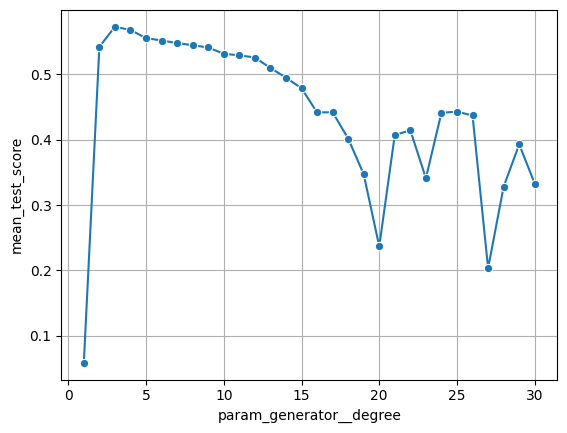

In [102]:
sns.lineplot(
    x = poly_grid_search2_df['param_generator__degree'],
    y = poly_grid_search2_df['mean_test_score'],
    marker = 'o'
)

plt.grid()

# very similar shape

## Leave One Out Cross-Validation

In [108]:
# and in the end lets use Leave One Out Cross-Validation 
# paired with the Randomized Search to find the optimal degree

# it does NOT loop over all potential (combinations of) hyperparameters but randomly
# selects a subset of them to evaluate

# it is more efficient than GridSearchCV for large hyperparameter spaces
# but does not guarantee to find the optimal hyperparameters

X = data1.drop(columns = 'y') # or data1['x']
y = data1['y']

# create a k-fold object
cv_loo = LeaveOneOut()

# create a randomized search object
poly_random_search = RandomizedSearchCV(
    poly_pipeline, # model or pipeline to tune
    # now we define a distribution of hyperparameters instead of a grid
    # (but in fact provide the same object as before)
    param_distributions = polyreg_grid,
    cv = cv_loo, # Difference: Leave One Out Cross-Validation
    n_iter = 10, # number of iterations (selected values)
    scoring = 'neg_mean_absolute_percentage_error', # Difference: MAPE metric
    n_jobs = -1 # use all available CPU cores (optional)
)

poly_random_search.fit(X, y)

print('Best degree:', poly_random_search.best_params_)
print('Best -MAPE:', poly_random_search.best_score_)

# is the result surprising

Best degree: {'generator__degree': 11}
Best -MAPE: -1.6895841354395058


In [112]:
# what values of the degree hyperparameter were tested

poly_random_search_df = pd.DataFrame(poly_random_search.cv_results_)

poly_random_search_df['param_generator__degree'].tolist()

# they do not include the optimal value of 3 
# because this is Randomized Search CV not GridSearchCV to cover all combinations

[21, 19, 26, 28, 18, 29, 13, 11, 14, 24]

## Using Cross-Validation to assess predictive performance on new data

In [115]:
# lets load the churn dataset AFTER encoding categorical predictors from a pickle file

churn_train_encoded = pd.read_pickle('data/churn_train_encoded.pkl')
churn_test_encoded = pd.read_pickle('data/churn_test_encoded.pkl')

churn_train_encoded.head()

,customer_id,customer_age,customer_number_of_dependents,customer_education,customer_salary_range,customer_relationship_length,customer_available_credit_limit,total_products,period_inactive,contacts_in_last_year,...,average_utilization,customer_gender_M,customer_gender_Unknown,customer_civil_status_Married,customer_civil_status_Single,customer_civil_status_Unknown,credit_card_classification_Gold,credit_card_classification_Platinum,credit_card_classification_Silver,account_status_1
4694,799562,50.0,2.0,2.0,1.0,37.0,13384.0,1.0,3.0,2.0,...,0.000,0,0,1,0,0,0,0,1,0
1263,282706,52.0,1.0,2.0,5.0,36.0,31945.0,4.0,3.0,5.0,...,0.050,1,0,0,0,0,0,0,0,0
4427,837683,46.0,3.0,1.0,3.0,36.0,5489.0,5.0,1.0,2.0,...,0.217,1,0,0,1,0,0,0,0,0
8746,384742,53.0,5.0,0.0,4.0,48.0,9517.0,6.0,1.0,0.0,...,0.196,1,0,1,0,0,0,0,0,0
4386,618362,59.0,0.0,4.0,2.0,53.0,4241.0,3.0,2.0,3.0,...,0.000,1,0,1,0,0,0,0,0,0


In [117]:
# using the training data only we will assess the performance of a logit model
# when used to predict the account_status on a new data - not used for model training

X = churn_train_encoded.drop(['account_status_1', 'customer_id'], axis = 1)
y = churn_train_encoded['account_status_1']

churn_model1 = LogisticRegression(
    penalty = None, # no regularization
    max_iter = 10000, # default is 100
    tol = 1e-2  # default is 1e-4
)

In [119]:
# Perform 5-fold cross-validation on the training data
cv5 = KFold(
    n_splits = 5, # number of blocks
    shuffle = True,
    random_state = 123
)

# apply modelling and get the value of the metric
# !!! if we evaluate just one model, we can use cross_val_score() function

scores = cross_val_score(
    churn_model1, # model
    X, # features
    y, # target
    cv = cv5, # above defined 5-fold cross-validation
    scoring = 'balanced_accuracy'
)

print(scores)

# the results include balanced accuracy for each fold

[0.7018345  0.69572191 0.72546669 0.71024607 0.72066047]


In [121]:
# lets calculate the mean of the scores
cv_ba = np.mean(scores)

print('Mean balanced accuracy based on 5-fold CV:', cv_ba)

Mean balanced accuracy based on 5-fold CV: 0.7107859275772979


In [123]:
churn_model1.fit(X, y)

# test data input features
X_test = churn_test_encoded.drop(['account_status_1', 'customer_id'], axis = 1)
y_test_actual = churn_test_encoded['account_status_1']

# make predictions on the test data
y_pred = churn_model1.predict(X_test)

# calculate the balanced accuracy
ba = balanced_accuracy_score(y_test_actual, y_pred)

print('Balanced accuracy on the test data:', ba)

# was the CV result a good predictor of the test result?

Balanced accuracy on the test data: 0.6972562993618703
